In [16]:
import os
import json
import re
import math
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage.io import imread, imsave
from skimage.transform import warp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp
from numba import njit, prange

In [13]:
def map_edt(p, edt, rs):
    rstep = np.mean(np.diff(rs))
    npos = p.shape[0]
    for i in range(npos):
        r,t = p[i,:].astype(int)
        # transformation from distance from the center
        p[i,0] = (edt[t,:,:].max() - rs[r]) / rstep
    return p

In [2]:
path_ext = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
#path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
#/Ti scope/2023_11_28/2023_11_28_10x_1.0x_pAAA_Ti_Pos6.ome.tif

In [3]:
scope_name = 'Tweez scope'
#scope_name = 'Ti scope'
path_scope = os.path.join(path_ext, scope_name)
exp_date = '2023_12_04'
df_date = '2023-12-04'
path = os.path.join(path_scope, exp_date)
folder_masks = 'contour_masks'
folder_results = 'results'
folder_fluo = 'fluo'
folder_graphs = 'graphs'
folder_velocity = 'velocity_data'
pos = 14
vectors = ['pAAA', 'pLPT20&41', 'pLPT107&41', 'pLPT119&41']
channels = {'pAAA': {'rfp':0,'yfp':1,'cfp':2,'phase':3},
            'pLPT20&41': {'yfp':0,'cfp':1,'phase':2}, 
            'pLPT119&41': {'yfp':0,'cfp':1,'phase':2},
            'pLPT107&41': {'rfp':0,'yfp':1,'cfp':2,'phase':3}}
scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
vector = 'pLPT107&41'

In [4]:
rfp_chn = 0
yfp_chn = 1
cfp_chn = 2
ph_chn = 3
fluo_chns = 3

In [5]:
fname = f'{exp_date}_10x_1.0x_{vector}_{scopes[scope_name]}_Pos{pos}.ome.tif'
fname

'2023_12_04_10x_1.0x_pLPT107&41_TiTweez_Pos14.ome.tif'

In [6]:
path_im = os.path.join(path, fname)
path_results = os.path.join(path, folder_results, f"pos{pos}")

In [7]:
#fname = '10x_1.0x_pAAA_-6_1_MMStack_Pos6.ome.tif'
im_all = imread(path_im)
#im_all = im_all.transpose([0,2,3,1])
#im_all = im_all[:,:,:,:ph_chn]
#im_all = imread(path_im)
nt,nx,ny,nc = im_all.shape
print(im_all.shape)

(216, 1024, 1024, 4)


In [8]:
bg = np.zeros((nc,))
for c in range(nc):
    bg[c] = im_all[0,:100,:100,c].mean()

In [9]:
im_all_bg = np.zeros_like(im_all)
for c in range(nc-1): 
    im_all_bg[:,:,:,c] = im_all[:,:,:,c] - bg[c]
im_all_bg[:,:,:,ph_chn] = im_all[:,:,:,ph_chn]

In [10]:
path_results = os.path.join(path, folder_results, f"pos{pos}")
edt = np.load(os.path.join(path_results,'edt.npy'))
edt = edt[:,:,:]

In [44]:
im_all = im_all[:,:,:,:ph_chn]
nt,nx,ny,nc = im_all.shape

In [46]:
## Just when fluo_chns = 3
nr = 64
rw = 8
rs = np.linspace(rw, edt.max(), nr)

cov = np.zeros((nt,nr,nc,nc))
corr = np.zeros((nt,nr,nc))
mean = np.zeros((nt,nr,nc))
for t in range(nt):
    for ri in range(nr):
        tedt = edt[t,:,:]
        idx = np.abs(tedt - rs[ri]) < rw
        if np.sum(idx)>0:
            #plt.figure()
            ntim0 = im_all[t,:,:,rfp_chn].astype(float) - bg[rfp_chn]
            ntim1 = im_all[t,:,:,yfp_chn].astype(float) - bg[yfp_chn]
            ntim2 = im_all[t,:,:,cfp_chn].astype(float) - bg[cfp_chn]
            x,y,z = ntim0[idx], ntim1[idx], ntim2[idx]
            C = np.cov(np.stack([x, y, z]))
            cov[t,ri,:,:] = C
            corr[t,ri,0] = np.corrcoef(x, y)[0,1]
            corr[t,ri,1] = np.corrcoef(x, z)[0,1]
            corr[t,ri,2] = np.corrcoef(y, z)[0,1]
            mean[t,ri,rfp_chn] = x.mean()
            mean[t,ri,yfp_chn] = y.mean()
            mean[t,ri,cfp_chn] = z.mean()
np.save(os.path.join(path_results, 'cov.npy'), cov)            
np.save(os.path.join(path_results, 'corr.npy'), corr)
np.save(os.path.join(path_results, 'mean.npy'), mean)

/tmp/ipykernel_309373/750090367.py:19: RuntimeWarning: Degrees of freedom <= 0 for slice
  C = np.cov(np.stack([x, y, z]))


In [47]:
corr_map = np.zeros_like(corr)
mean_map = np.zeros_like(mean)
for c in range(fluo_chns):
    corr_map[:,:,c] = warp(corr[:,:,c], map_edt, {'edt':edt, 'rs':rs})
    mean_map[:,:,c] = warp(mean[:,:,c], map_edt, {'edt':edt, 'rs':rs})
corr_map[np.isnan(corr)] = np.nan
mean_map[np.isnan(mean)] = np.nan

#### Correlation kymos

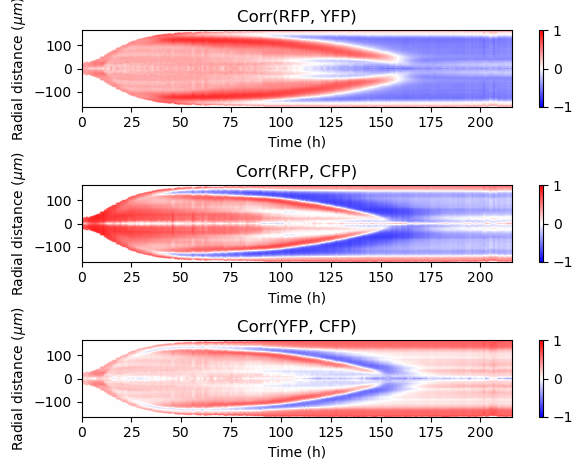

In [48]:
t0 = 0

plt.subplot(3,1,1)
plt.imshow(np.hstack([corr_map[t0:,::-1,0],corr_map[t0:,:,0]]).transpose(), 
           extent=[0,nt,-edt.max(),edt.max()], 
           aspect='auto', 
           cmap='bwr', 
           vmin=-1, 
           vmax=1)
plt.xlabel('Time (h)')
plt.ylabel(r'Radial distance $(\mu m)$')
plt.title('Corr(RFP, YFP)')
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(np.hstack([corr_map[t0:,::-1,1],corr_map[t0:,:,1]]).transpose(), 
           extent=[0,nt,-edt.max(),edt.max()],  
           aspect='auto', 
           cmap='bwr', 
           vmin=-1, 
           vmax=1)
plt.xlabel('Time (h)')
plt.ylabel(r'Radial distance $(\mu m)$')
plt.title('Corr(RFP, CFP)')
plt.colorbar()

plt.subplot(3,1,3)
plt.imshow(np.hstack([corr_map[t0:,::-1,2],corr_map[t0:,:,2]]).transpose(), 
           extent=[0,nt,-edt.max(),edt.max()],  
           aspect='auto', 
           cmap='bwr', 
           vmin=-1, 
           vmax=1)
plt.xlabel('Time (h)')
plt.ylabel(r'Radial distance $(\mu m)$')
plt.title('Corr(YFP, CFP)')
plt.colorbar()

plt.tight_layout()

#### Mean fluo kymos

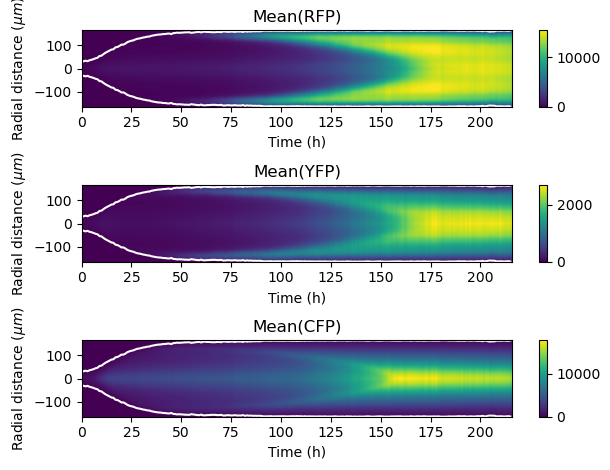

In [71]:
t0 = 0

radius = edt.max(axis=(1,2))
#plt.plot(cx - radius, np.arange(nt), 'w')

plt.subplot(3,1,1)
plt.imshow(np.hstack([mean_map[t0:,::-1,rfp_chn],mean_map[t0:,:,rfp_chn]]).transpose(), 
                   extent=[0,nt,-edt.max(),edt.max()], 
                   aspect='auto')
plt.plot(np.arange(nt), radius, 'w')
plt.plot(np.arange(nt), -radius, 'w')
plt.xlabel('Time (h)')
plt.ylabel(r'Radial distance $(\mu m)$')
plt.title('Mean(RFP)')
plt.colorbar(aspect=10)

plt.subplot(3,1,2)
plt.imshow(np.hstack([mean_map[t0:,::-1,yfp_chn],mean_map[t0:,:,yfp_chn]]).transpose(), 
           extent=[0,nt,-edt.max(),edt.max()], 
           aspect='auto')
plt.plot(np.arange(nt), radius, 'w')
plt.plot(np.arange(nt), -radius, 'w')
plt.xlabel('Time (h)')
plt.ylabel(r'Radial distance $(\mu m)$')
plt.title('Mean(YFP)')
plt.colorbar(aspect=10)

plt.subplot(3,1,3)
plt.imshow(np.hstack([mean_map[t0:,::-1,cfp_chn],mean_map[t0:,:,cfp_chn]]).transpose(), 
           extent=[0,nt,-edt.max(),edt.max()], 
           aspect='auto')
plt.plot(np.arange(nt), radius, 'w')
plt.plot(np.arange(nt), -radius, 'w')
plt.xlabel('Time (h)')
plt.ylabel(r'Radial distance $(\mu m)$')
plt.title('Mean(CFP)')
plt.colorbar(aspect=10)

plt.tight_layout()

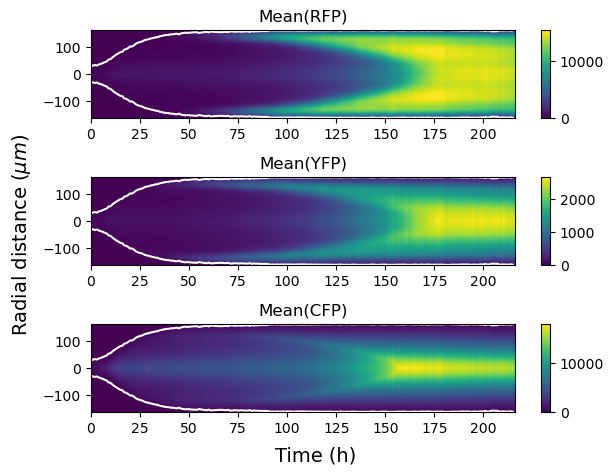

In [75]:
t0 = 0

plt.subplot(3, 1, 1)
plt.imshow(np.hstack([mean_map[t0:, ::-1, rfp_chn], mean_map[t0:, :, rfp_chn]]).transpose(), 
           extent=[0, nt, -edt.max(), edt.max()], 
           aspect='auto')
plt.plot(np.arange(nt), radius, 'w')
plt.plot(np.arange(nt), -radius, 'w')
plt.title('Mean(RFP)')
plt.colorbar(aspect=10)

plt.subplot(3, 1, 2)
plt.imshow(np.hstack([mean_map[t0:, ::-1, yfp_chn], mean_map[t0:, :, yfp_chn]]).transpose(), 
           extent=[0, nt, -edt.max(), edt.max()], 
           aspect='auto')
plt.plot(np.arange(nt), radius, 'w')
plt.plot(np.arange(nt), -radius, 'w')
plt.title('Mean(YFP)')
plt.colorbar(aspect=10)

plt.subplot(3, 1, 3)
plt.imshow(np.hstack([mean_map[t0:, ::-1, cfp_chn], mean_map[t0:, :, cfp_chn]]).transpose(), 
           extent=[0, nt, -edt.max(), edt.max()], 
           aspect='auto')
plt.plot(np.arange(nt), radius, 'w')
plt.plot(np.arange(nt), -radius, 'w')
plt.title('Mean(CFP)')
plt.colorbar(aspect=10)

# Remove individual x and y labels
plt.xlabel('')
plt.ylabel('')

# Add shared x and y labels
plt.gcf().text(0.5, 0.04, 'Time (h)', ha='center', va='center', fontsize=14)
plt.gcf().text(0.04, 0.5, r'Radial distance $(\mu m)$', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to make room for the shared labels
plt.show()
